In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
data = pd.concat([pd.read_csv('winequality-red.csv', sep = ';'),
                  pd.read_csv('winequality-white.csv', sep = ';')])

n,k=data.shape
data['Constante'] = np.full(n, 1)
#data = data.sample(data.shape[0])
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Constante
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [45]:
from sklearn.preprocessing import normalize

In [46]:
y = data[['quality']].values
x = data.drop(['quality'], axis=1).values
x = normalize(x)

In [47]:
def predicteur(t, x):
    return np.dot(t, x)
    
def loss(y_, y):
    return np.abs(y_-y)

def gradient(t,x,y):
    return np.sign(predicteur(t,x) - y)*x


In [50]:
def gradient_en_ligne(x,y,t_0 = np.full(k, 1), eta=0.01):  
    n = y.shape[0]
    t = [t_0]
    error = []
    prediction = []
    for k in range(n-1):
        t += [ t[k] - eta*gradient(t[k], x[k,:],y[k])]
        prediction += [predicteur(t[k+1], x[k+1,:])]
        error +=[ float(loss(predicteur(t[k+1], x[k+1,:]), y[k+1])) ]
    
    return error

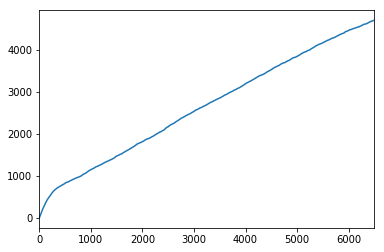

In [51]:
pd.Series(np.cumsum(gradient_en_ligne(x,y))).plot()